In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py

--2025-04-09 06:13:45--  https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-04-09 06:13:45 (7.88 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves

(np.float64(-0.5), np.float64(639.5), np.float64(426.5), np.float64(-0.5))

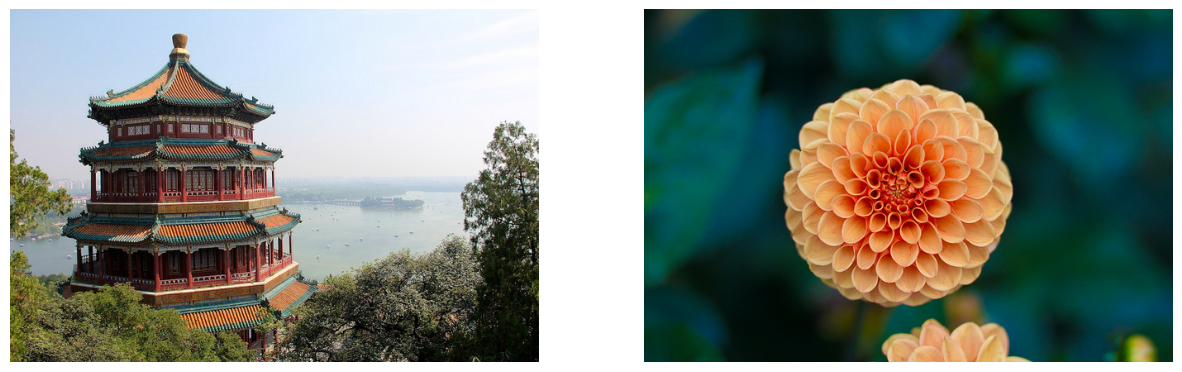

In [ ]:
images = load_sample_images()['images']
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

(np.float64(-0.5), np.float64(119.5), np.float64(69.5), np.float64(-0.5))

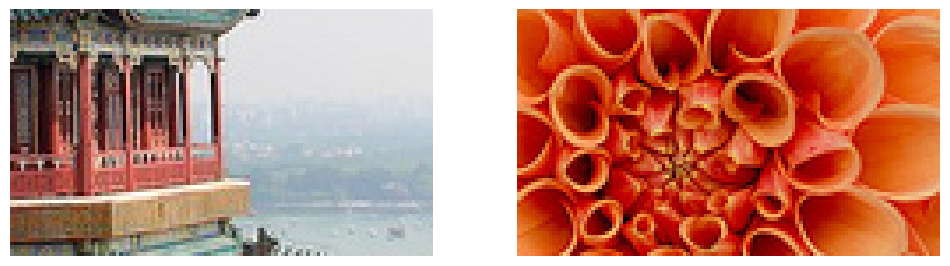

In [ ]:
images = tf.keras.layers.CenterCrop(height=70,width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255.)(images)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

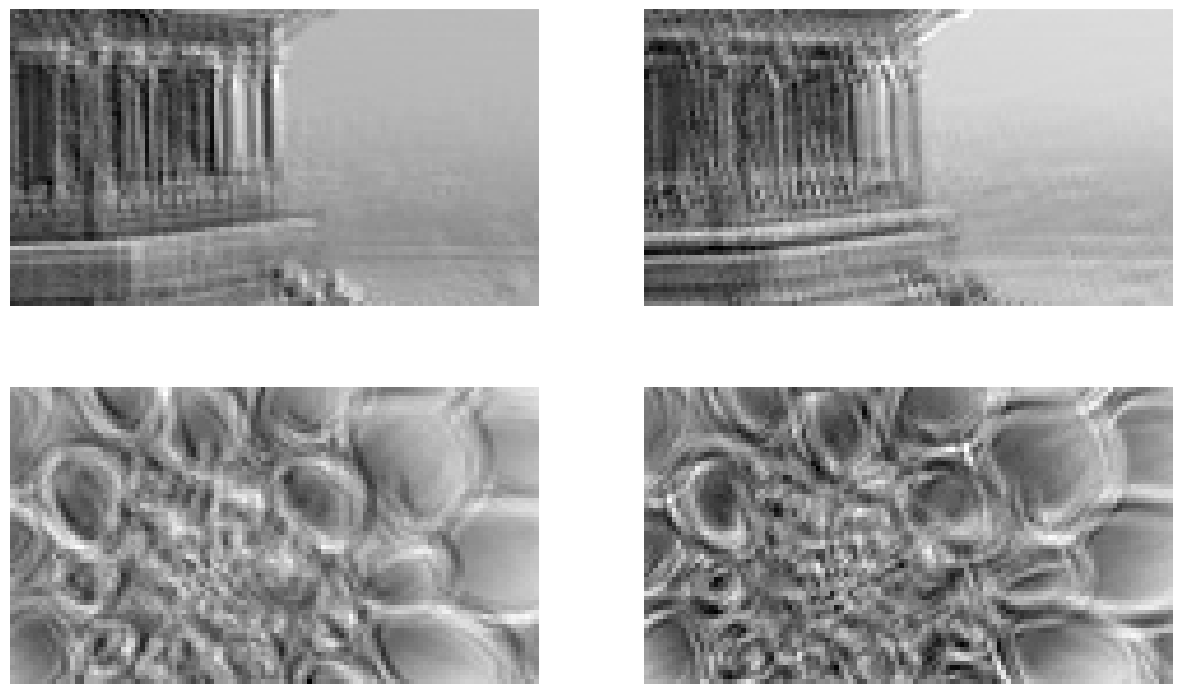

In [ ]:
plt.figure(figsize=(15,9))
for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2,image_idx * 2 + fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx],cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding='same')
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding='same',strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
import numpy as np

In [ ]:
def conv_output_size(input_size,kernel_size,strides=1,padding='valid'):
  if padding == 'valid':
    z = input_size - kernel_size + strides
    output_size = z // strides
    num_ignored = z % strides
    return output_size, num_ignored
  else:
    output_size = (input_size - 1) // strides + 1
    num_padded = (output_size - 1) % strides + kernel_size - input_size
    return output_size, num_padded

conv_output_size(np.array([70,120]),kernel_size=10,strides=4,padding='same')

(array([18, 30]), array([ -59, -109]))

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [ ]:
tf.random.set_seed(42)
filters = tf.random.normal([7,7,3,2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images,filters,strides=1,padding='SAME') + biases

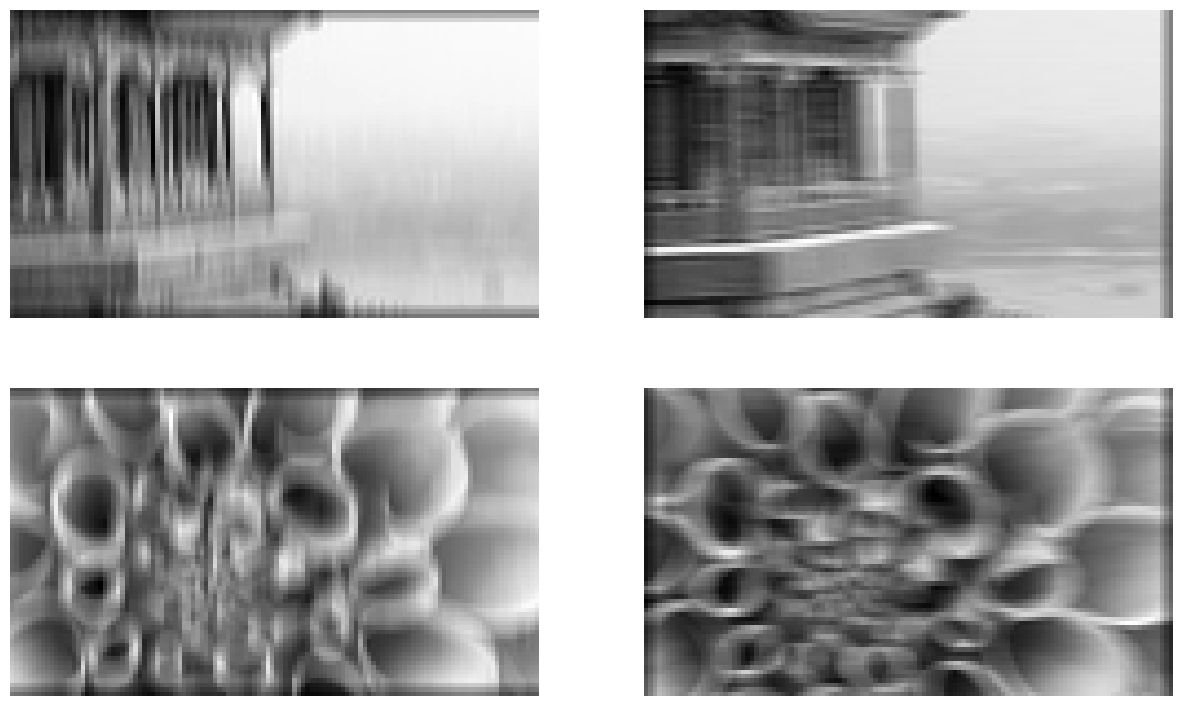

In [ ]:
plt.figure(figsize=(15,9))
filters = np.zeros([7,7,3,2])
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1
fmaps = tf.nn.conv2d(images,filters,strides=1,padding='SAME') + biases
for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2,image_idx * 2 + fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx],cmap='gray')
    plt.axis('off')

plt.show()

# Implementing Pooling layes with Keras

# Max Pooling

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)

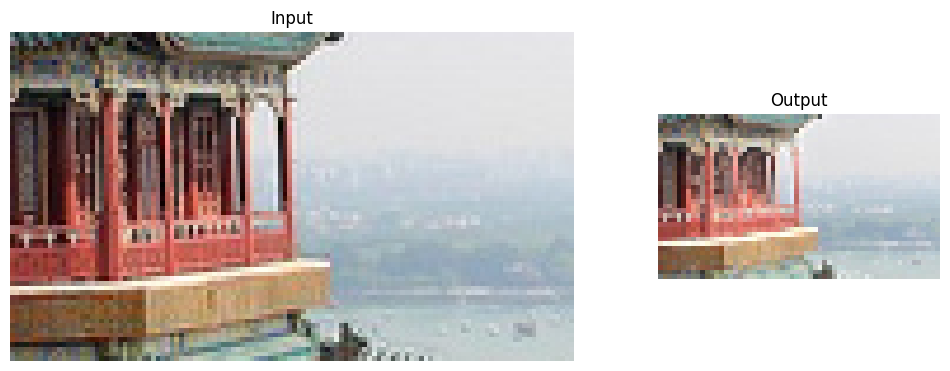

In [ ]:
import matplotlib as mpl

fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1,ncols=2,width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title('Input')
ax1.imshow(images[0])
ax1.axis('off')

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title('Output')
ax2.imshow(output[0])
ax2.axis('off')
plt.show()

In [ ]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self,pool_size=2,**kwargs):
    super().__init__(**kwargs)
    self.pool_size=pool_size

  def call(self,inputs):
    shape = tf.shape(inputs)
    groups = shape[-1] // self.pool_size
    new_shape = tf.concat([shape[:-1],[groups, self.pool_size]],axis=0)
    return tf.reduce_max(tf.reshape(inputs,new_shape),axis=1)

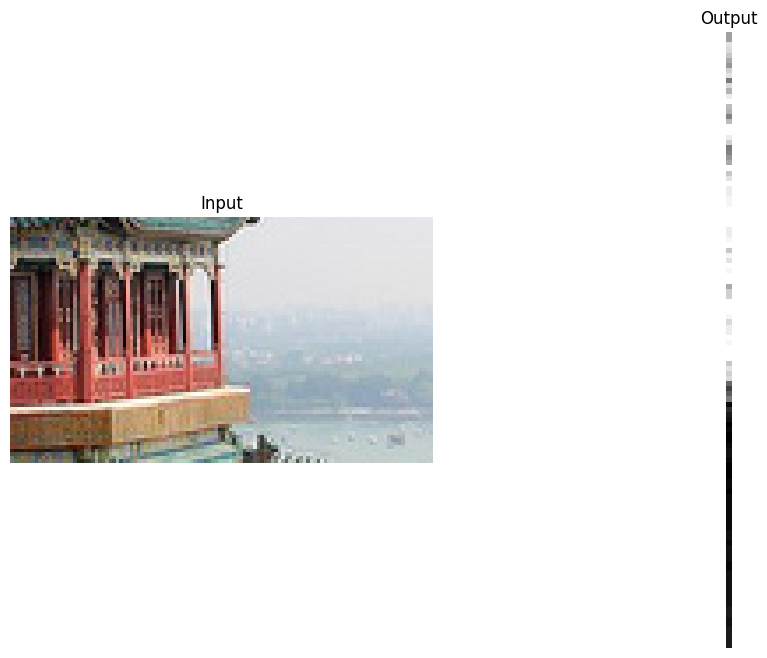

In [ ]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Input')
plt.imshow(images[0])
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Output')
plt.imshow(depth_output[0,...,0],cmap='gray')
plt.axis('off')
plt.show()

# CNN Architectures

# Tacklin Fashion MNIST with a CNN

In [ ]:
mnist=tf.keras.datasets.fashion_mnist.load_data()
(X_train_full,y_train_full),(X_test,y_test)=mnist
X_train_full=np.expand_dims(X_train_full,axis=-1).astype(np.float32) / 255
X_test=np.expand_dims(X_test.astype(np.float32),axis=-1) / 255
X_train, X_valid=X_train_full[:-5000],X_train_full[-5000:]
y_train,y_valid=y_train_full[:-5000],y_train_full[-5000:]

In [ ]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,padding='same',activation='relu',kernel_initializer='he_normal')

model=tf.keras.Sequential([
    DefaultConv2D(filters=64,kernel_size=7,input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32,activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])
history=model.fit(X_train,y_train,epochs=10,
                  validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)
X_new=X_test[:10]
y_pred=model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 654s 378ms/step - accuracy: 0.2884 - loss: 1.8107 - val_accuracy: 0.4794 - val_loss: 1.1735
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 658s 364ms/step - accuracy: 0.5137 - loss: 1.1363 - val_accuracy: 0.7374 - val_loss: 0.6538
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 665s 354ms/step - accuracy: 0.7271 - loss: 0.7339 - val_accuracy: 0.8666 - val_loss: 0.4119
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 553s 314ms/step - accuracy: 0.8120 - loss: 0.5568 - val_accuracy: 0.8724 - val_loss: 0.3953
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 564s 315ms/step - accuracy: 0.8357 - loss: 0.4898 - val_accuracy: 0.8864 - val_loss: 0.3661
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 557s 313ms/step - accuracy: 0.8466 - loss: 0.4569 - val_accuracy: 0.8924 - val_loss: 0.3532
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 543s 316ms/step - accuracy: 0.8638 - loss: 0.4179 - val_accuracy: 0.8872 - val_loss: 0.3572
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 558s 314ms/step - ac

# Implementing a ResNet-34 CNN Using Keras

In [ ]:
DefaultConv2D = partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,padding='same',kernel_initializer='he_normal',use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self,filters,strides=1,activation='relu',**kwargs):
    super().__init__(**kwargs)
    self.activation=tf.keras.activations.get(activation)
    self.main_layers=[
        DefaultConv2D(filters,strides=strides),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        tf.keras.layers.BatchNormalization()
    ]

    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
          DefaultConv2D(filters,kernel_size=1,strides=strides),
          tf.keras.layers.BatchNormalization()
      ]

  def call(self,inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.main_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z+skip_Z)

In [ ]:
model=tf.keras.Sequential([
    DefaultConv2D(64,kernel_size=7,strides=2,input_shape=[224,224,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')
])

prev_filters=64
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
  strides=1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters,strides=strides))
  prev_filters=filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_unit_35', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_unit_39', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_unit_45', however the 

# Using a Petrained Models from Keras

In [ ]:
model=tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
images=load_sample_images()['images']
images_resized=tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True)(images)

In [ ]:
inputs=tf.keras.applications.resnet50.preprocess_input(images_resized)

In [ ]:
Y_proba=model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(2, 1000)

In [ ]:
Y_proba

array([[5.3595841e-07, 8.1552156e-05, 7.4939276e-06, ..., 5.6788309e-08,
        1.1921661e-04, 2.3534778e-05],
       [1.5941704e-07, 7.7845230e-05, 2.1639423e-07, ..., 6.2884710e-06,
        1.2104815e-05, 1.4500229e-05]], dtype=float32)

In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba,top=3)
for image_index in range(len(images)):
  print(f'Image #{image_index}')
  for class_id,name,y_proba in top_K[image_index]:
    print(f' {class_id} - {name:12s} {y_proba:.2%}')

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
Image #0
 n03598930 - jigsaw_puzzle 30.68%
 n02782093 - balloon      17.17%
 n03888257 - parachute    5.57%
Image #1
 n04209133 - shower_cap   34.37%
 n09229709 - bubble       11.41%
 n02782093 - balloon      9.46%


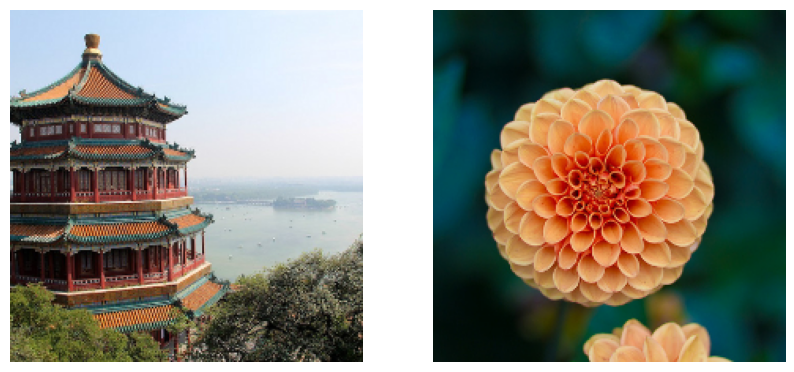

In [ ]:
plt.figure(figsize=(10,6))
for idx in (0,1):
  plt.subplot(1,2,idx+1)
  plt.imshow(images_resized[idx] / 255)
  plt.axis('off')

plt.show()